## Introducing qBang: a python implementation of the qBang optimization algorithm
qBang is a powerful quantum optimizer that can be used to optimize variational quantum circuits (VQCs). This tutorial guides you through the optimization of a VQC with qBang. It is divided into three sections:

1. Introduction to the Barren Plateau Circuit
2. Introduction to qBang
3. Optimization of a Barren Plateau Circuit with qBang

In this tutorial, we use PennyLane to simulate quantum circuits and to interface with qBang.

In [25]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from pennylane import AdamOptimizer, QNGOptimizer
from tqdm import tqdm
from utils.barren_plateau_circuit import BarrenPlateauCircuit

from qbang.optimizer import MomentumQNGOptimizer, QBangOptimizer, QBroydenOptimizer

# Barren plateau prone circuit

The Barren Plateau Circuit is a type of VQC that is particularly challenging to optimize because its gradients vanish exponentially with the number of qubits. In this tutorial, we work with an instance of the Barren Plateau Circuit with 8 qubits and 4 layers. While vanishing gradients are not an issue for such small-sized circuits, we use this instance for demonstration purposes.

We start by defining the Hamiltonian that we wish to minimize. The Hamiltonian is defined as $\hat H=\hat Z_1\hat Z_2$ with a ground state energy of $-1$.

We then define the Barren Plateau Circuit and wrap it into a qnode. The qnode allows us to evaluate the expectation value of the Hamiltonian with respect to the circuit parameters.

In [40]:
# Hamiltonian
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]
coeffs = [1.0]
H = qml.Hamiltonian(coeffs, obs)

In [41]:
# Circuit
seed = 0

circuit = BarrenPlateauCircuit(num_layers=4, num_qubits=8)
params = circuit.init(seed=seed)

In [44]:
# Visualize the circuit
print(qml.draw(circuit)(params))

0: ──RY(0.79)──RX(1.39)──╭||─╭●───────────────────╭||──RX(-1.78)─╭||─╭●───────────────────╭||
1: ──RY(0.79)──RY(0.52)──├||─╰Z─╭●────────────────├||──RX(-2.29)─├||─╰Z─╭●────────────────├||
2: ──RY(0.79)──RX(0.23)──├||────╰Z─╭●─────────────├||──RX(-1.10)─├||────╰Z─╭●─────────────├||
3: ──RY(0.79)──RY(1.62)──├||───────╰Z─╭●──────────├||──RZ(-2.20)─├||───────╰Z─╭●──────────├||
4: ──RY(0.79)──RY(-2.48)─├||──────────╰Z─╭●───────├||──RY(-1.74)─├||──────────╰Z─╭●───────├||
5: ──RY(0.79)──RZ(-0.17)─├||─────────────╰Z─╭●────├||──RZ(-0.71)─├||─────────────╰Z─╭●────├||
6: ──RY(0.79)──RX(-1.97)─├||────────────────╰Z─╭●─├||──RZ(2.53)──├||────────────────╰Z─╭●─├||
7: ──RY(0.79)──RZ(1.49)──╰||───────────────────╰Z─╰||──RX(-0.31)─╰||───────────────────╰Z─╰||

───RY(0.71)──╭||─╭●───────────────────╭||──RY(0.68)──╭||─╭●───────────────────╭||─┤  
───RY(2.53)──├||─╰Z─╭●────────────────├||──RZ(-1.10)─├||─╰Z─╭●────────────────├||─┤  
───RY(-2.52)─├||────╰Z─╭●─────────────├||──RX(-2.90)─├||────╰Z─╭●──────────

In [45]:
# QNode
# wires is based on the number of qubits but for the full quantum Fisher information
# we require an auxilliary qubit for measuring.
dev = qml.device("default.qubit", wires=range(len(circuit.wires) + 1))


@qml.qnode(dev)
def loss_fn(x):
    circuit(x)
    return qml.expval(H)

## Optimization with qBang

We compare qBang with several other optimization algorithms from PennyLane. We iterate over each optimizer and for each optimizer, we run a certain number of optimization steps.

We store the optimization data in a Datapoint dataclass and then use it to create a DataFrame that allows us to easily visualize the results of the optimization.

Finally, we plot the expectation value of the Hamiltonian as a function of the number of optimization steps for each optimizer. We also include a black dotted line representing the ground state energy of the Hamiltonian.

Note that qBang is the most efficient optimizer in terms of the number of optimization steps and therefore also in the number of quantum circuit evaluations.

In [31]:
stepsize = 0.01
steps = 200

Let us iterate over the different optimizer

In [32]:
list_optimizer = [
    AdamOptimizer(stepsize=stepsize),
    QNGOptimizer(stepsize=stepsize, approx="block-diag", lam=1e-7),
    MomentumQNGOptimizer(stepsize=stepsize, approx="block-diag", lam=1e-7),
    QBroydenOptimizer(stepsize=stepsize, approx="block-diag", lam=1e-7),
    QBangOptimizer(stepsize=stepsize, approx="block-diag", lam=1e-7),
]

to store and handle the data we create a dataclass

In [33]:
@dataclass
class Datapoint:
    step: int
    exp_val: float
    optimizer: str

In [34]:
dataset = []
for optimizer in list_optimizer:
    optimizer_id = optimizer.__class__.__name__
    print(optimizer_id)
    params = circuit.init(seed)

    for k in tqdm(range(0, steps + 1)):
        params, exp_val = optimizer.step_and_cost(loss_fn, params)
        dataset.append(Datapoint(k, np.real(exp_val), optimizer_id))

    del optimizer

AdamOptimizer


100%|██████████| 201/201 [00:05<00:00, 37.18it/s]


QNGOptimizer


100%|██████████| 201/201 [00:34<00:00,  5.88it/s]


MomentumQNGOptimizer


100%|██████████| 201/201 [00:20<00:00,  9.70it/s]


QBroydenOptimizer


100%|██████████| 201/201 [00:07<00:00, 26.49it/s]


QBangOptimizer


100%|██████████| 201/201 [00:07<00:00, 26.20it/s]


In [35]:
df = pd.DataFrame(
    columns=[
        "step",
        "exp_val",
        "optimizer",
    ]
)

df = pd.DataFrame([x.__dict__ for x in dataset])
df["exp_val"] = df["exp_val"].astype(float) 

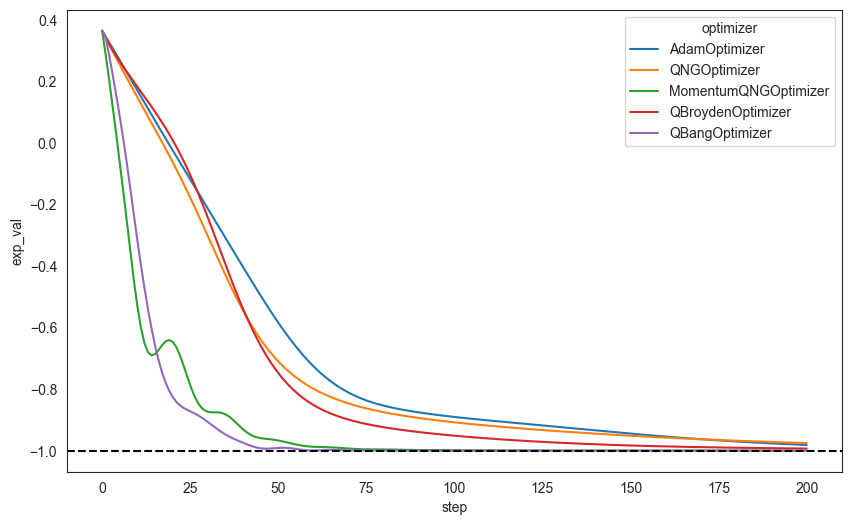

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("white")

g = sns.lineplot(
    x="step",
    y="exp_val",
    hue="optimizer",
    data=df,
    ax=ax,
)

ax.axhline(y=-1, color="black", linestyle="--", label="Ground state")